In [98]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from abtem import *
from ase.io import read
from ase import Atoms

# STEM simulations with PRISM

Multslice simulations from STEM images can be very slow because the scattering of the electron probe is calculated from scratch at each pixel of the image. An alternative is to use the [PRISM algorithm](https://prism-em.com) developed by Colin Ophus. PRISM almost always provides a decent speed-up for images with many probe positions, and allows for huge speedups, at a modest cost to accuracy, by using Fourier interpolation.

## Basic simulations

In abTEM, you simulate STEM images using a `SMatrix` object. This requires two parameters that are quite different than in STEM with the normal multislice method. 

The `expansion_cutoff` corresponds to the maximum scattering angle computed for the S-Matrix, and its value should be set slightly larger than the probe semiangle cutoff, which we will set later. Increasing this value, also increases the number of plane wave in the probe expansion, and hence the cost and memory of the simulation.

By setting the interpolation factor to one, the PRISM algorithm converges to the normal multislice method. Increasing this factor decreases the accuracy of PRISM, but the tradeoff can be very favorable. More on how to choose this later.

In [100]:
S = SMatrix(expansion_cutoff=32, 
            interpolation=1, 
            energy=80e3,
            semiangle_cutoff=30,
            defocus=50,
            focal_spread=60)

Here we simulate the exact same image as in part 6 of the walkthrough but now using PRISM. We first import our atoms and create the potential, the detector and the scan (see part 6 for more). Of course all the objects are interchangeable.

In [101]:
atoms = read('data/orthogonal_graphene.cif') 

potential = Potential(atoms, sampling=.03)

detector = AnnularDetector(inner=86, outer=190)

gridscan = GridScan(start=[0, 0], end=[np.sqrt(3) * 1.42, 3 * 1.42], sampling=.1)

The image can be simulated using `.scan` method.

In [102]:
measurements = S.scan(gridscan, [detector], potential)

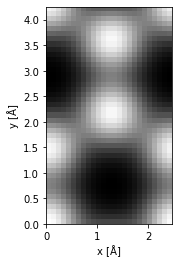

In [103]:
measurements[detector].show();

## The scattering matrix

The `SMatrix` object handles the PRISM algorithm behind the scenes. For more control you can build the scattering matrix return a `SMatrixArray`. This is equivalent to the `SMatrix`, however it is now represented as an array.

In [104]:
S_array = S.build()

The plane wave expansion as a numpy array can be obtained as `S_array.array`. Its first dimension indexes the plane waves by their 2D wave vector, given in the array `S_array.k`. In this case the expansion consists of 119 plane waves.

In [106]:
S_array.array.shape, S_array.k.shape

((119, 246, 285), (119, 2))

To obtain a probe wave function, we have to sum up the expansion, given a particular set of positions. This can be done with the `.collapse` method.

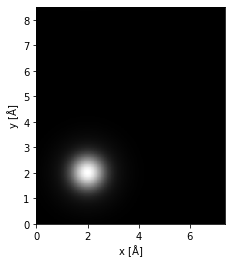

In [107]:
probes = S_array.collapse(positions=[(2,2),(5,5)])

probes[0].show()

We can propagate the scattering matrix through the potential.

In [108]:
exit_S_array = S_array.multislice(potential)

The imaging parameters of the represented probes can be modified after performing the multislice simulation using the builtin contrast transfer function.

In [109]:
exit_S_array.ctf.semiangle_cutoff = 20
exit_S_array.ctf.defocus = -50

We can finally perform the STEM simulation.

In [110]:
exit_S_array.scan(gridscan, [detector])

{<abtem.detect.AnnularDetector at 0x19faca20088>: <abtem.measure.Measurement at 0x19fadbc5e48>}

## Interpolation factor

The highest spatial frequency included in the plane wave expansion will be smaller by the interpolation factor. This can more intuitively be thought of as restricting the extent of the probe window. We copy the scattering matrix above and set its interpolation factor to 2.

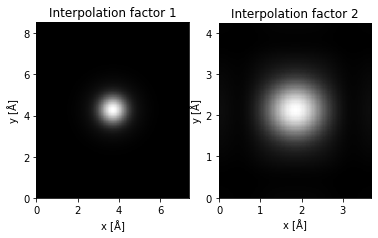

In [111]:
S2 = S.copy()
S2.interpolation = 2

fig, (ax1, ax2) = plt.subplots(1, 2)
S.show(ax=ax1, title='Interpolation factor 1')
S2.show(ax=ax2, title='Interpolation factor 2')

The simulation was faster, however, we see huge errors in the resulting image.

(<matplotlib.axes._subplots.AxesSubplot at 0x19fb0439a08>,
 <matplotlib.image.AxesImage at 0x19fb06148c8>)

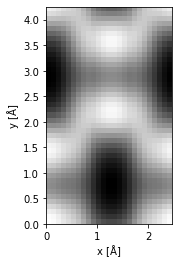

In [125]:
measurements2 = S2.scan(gridscan, [detector], potential, pbar=False)
measurements2[detector].show()

The error is because the probe is too large to fit in the probe window. Our unit cell is too small that it is possible to use interpolation (for this probe size). This would of course be different for larger cells with thousands of atoms.

We emulate that situation by just repeating the unit cell by a factor of 2.

In [177]:
potential2 = Potential(atoms * (2, 2, 1), sampling=.03)

The multislice part of the simulation will be more expensive, however, due to the interpolation, the scanning part will be cost virtually the same.

In [183]:
measurements3 = S2.scan(gridscan, [detector], potential2, pbar=True)

(<matplotlib.axes._subplots.AxesSubplot at 0x19fafa80c08>,
 <matplotlib.image.AxesImage at 0x19faf9ead48>)

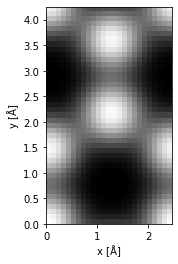

In [184]:
measurements3[detector].show()